# This notebook contains the Stacks parameter tests, final parameters used and analyses to identify sex linked markers for the RADseq dataset of <i> Rana saharicus</i> 
## Sample set:

several populations from Morrocco

In [3]:
%matplotlib inline
import os
import wget ## used "sudo pip install wget" in command line to get package.
import Incremental_U as IncU ## Get this sorted
import Incremental_C as IncC
import Incremental_Pop_mod as IncPop
import MISC_RAD_tools as MISC
import pprint
import subprocess

In [4]:
%load_ext rpy2.ipython

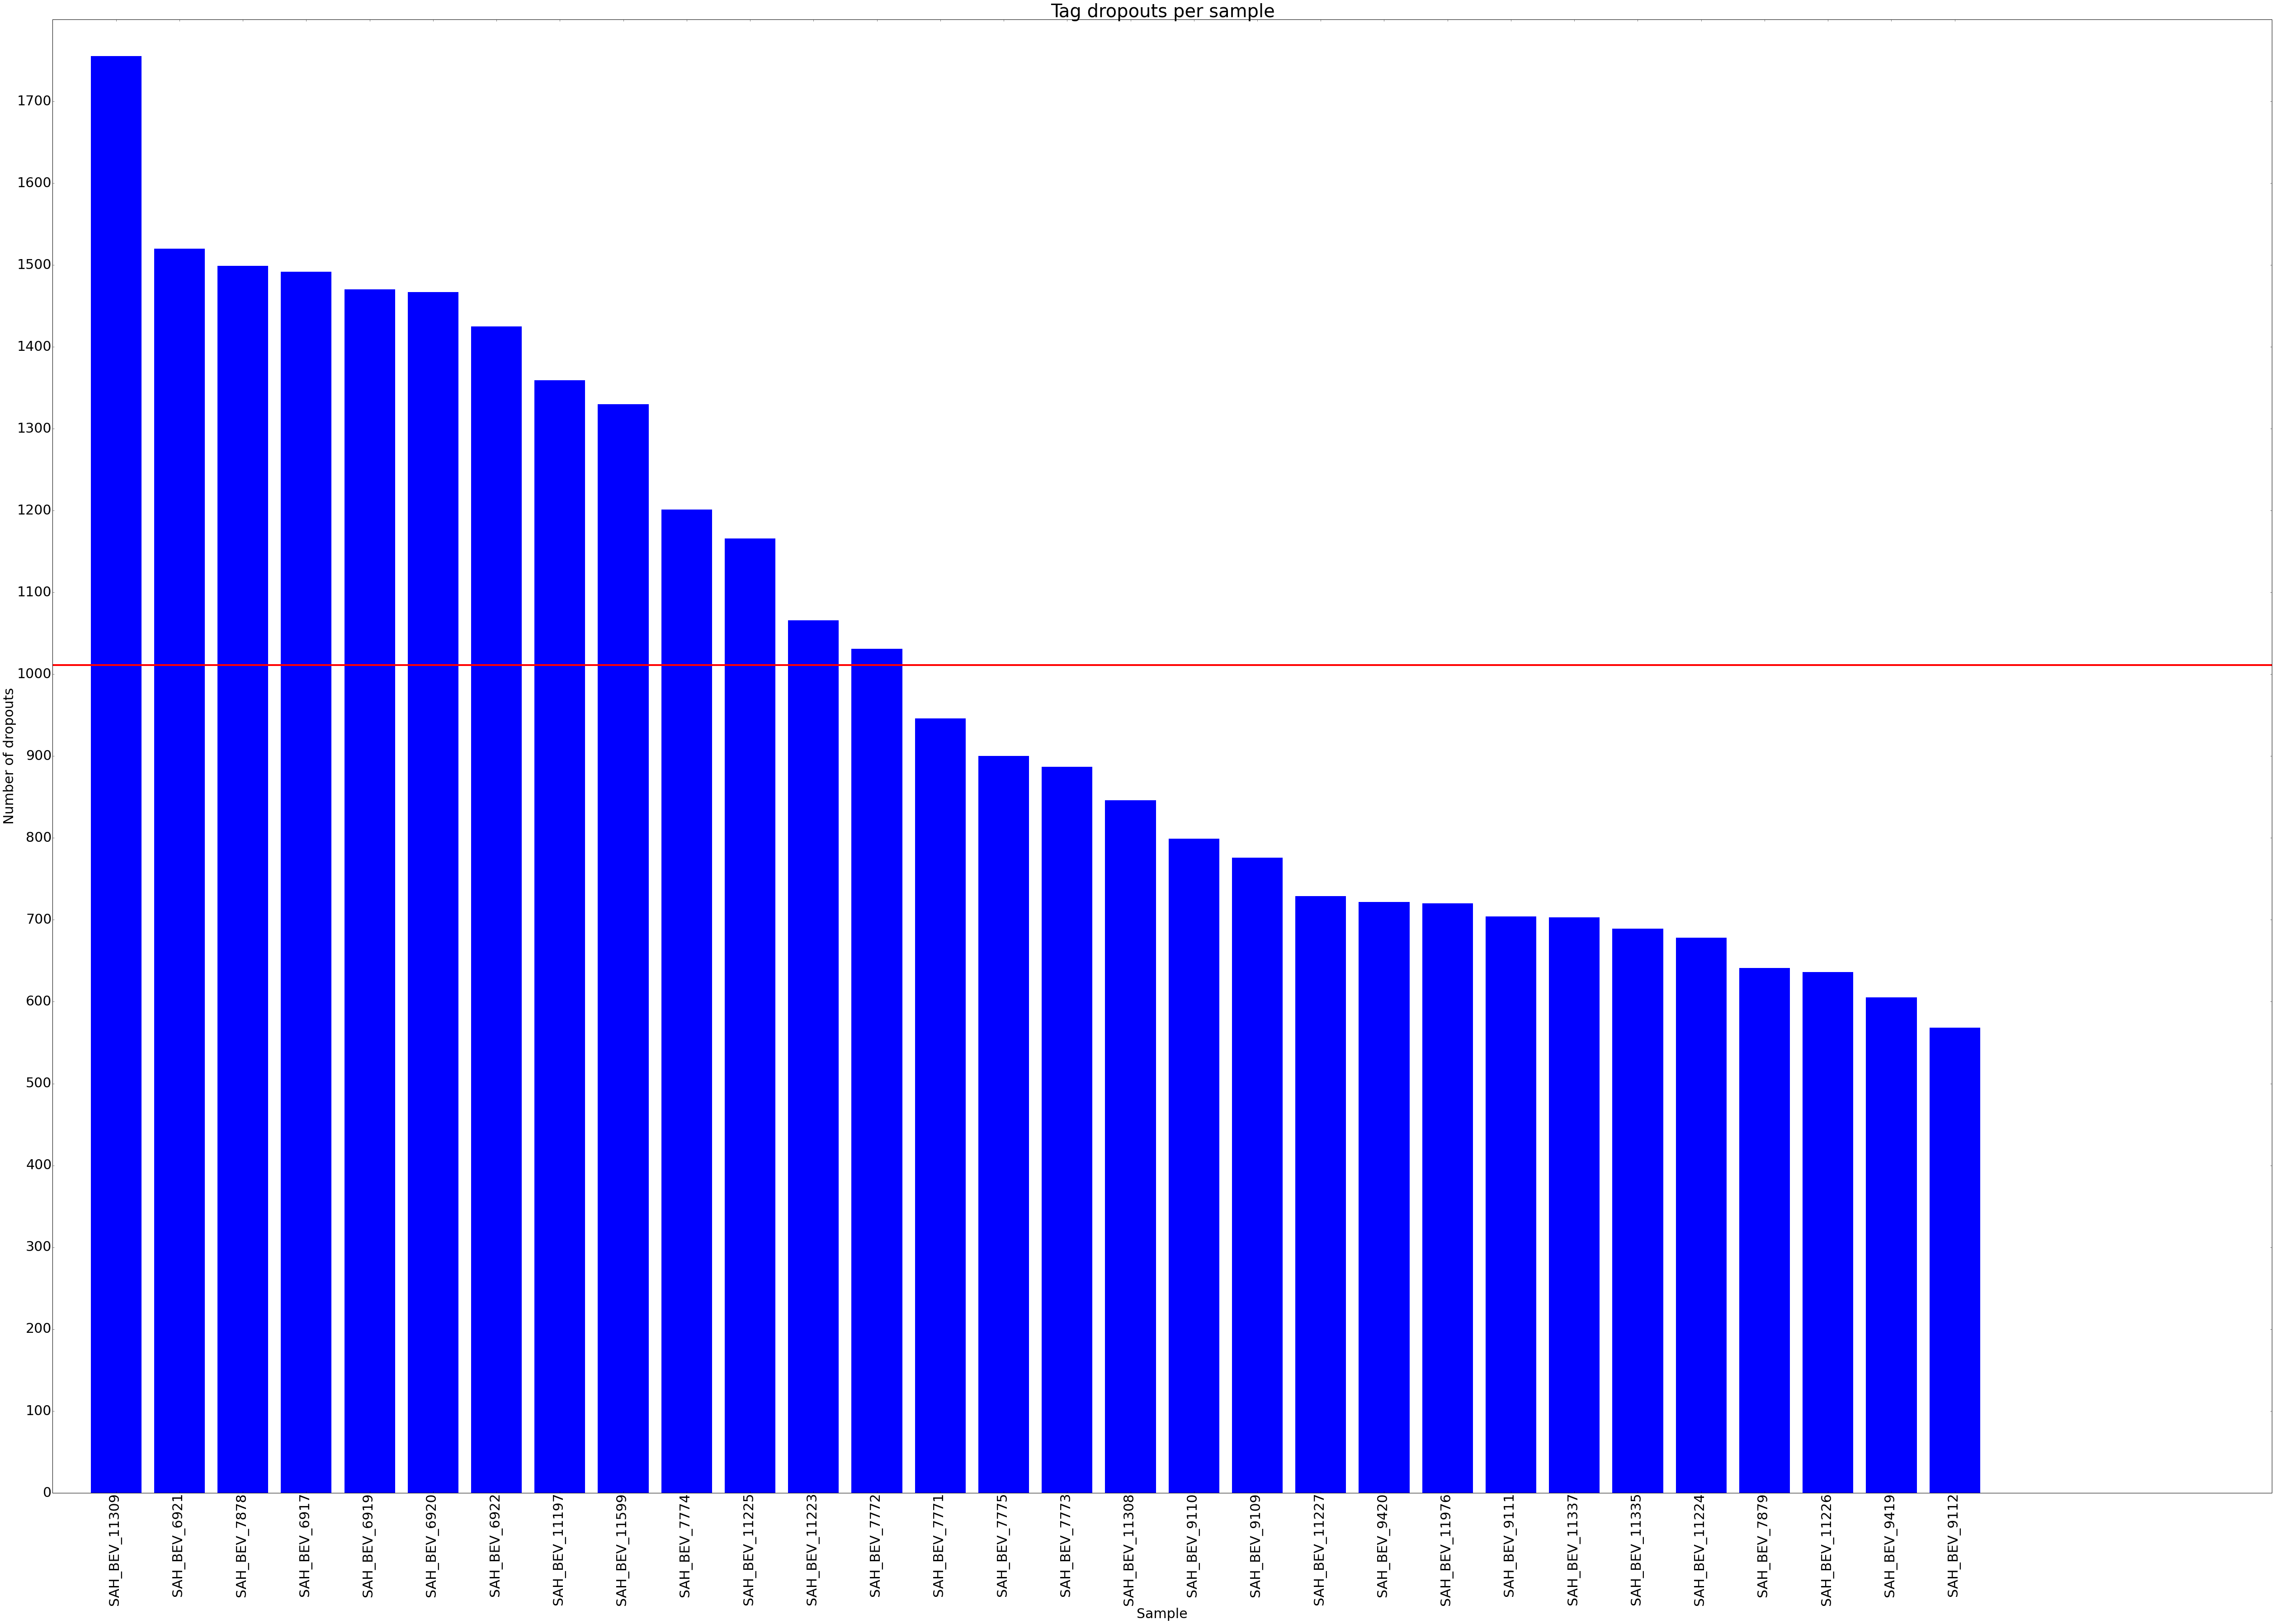

Outputs written to:
/home/djeffrie/Data/RADseq/Psaharicus//Tag_dropouts_per_sample.txt
/home/djeffrie/Data/RADseq/Psaharicus//Tag_dropouts_per_tag.txt
/home/djeffrie/Data/RADseq/Psaharicus//Tag_dropouts_per_sample.pdf
/home/djeffrie/Data/RADseq/Psaharicus//Tag_dropouts_per_tag.pdf
/home/djeffrie/Data/RADseq/Psaharicus//blacklist.txt


In [3]:
wd = "/home/djeffrie/Data/RADseq/Psaharicus/"

blacklist = MISC.missing_data_finder("%s/batch_1.vcf" % wd, wd)

#### Check the final snp dataset, e.g. amount of locus/ sample dropout, coverage etc

Number of tags =  2731
Average tag coverage 10.5068228976 (+- 6.9499144679 )


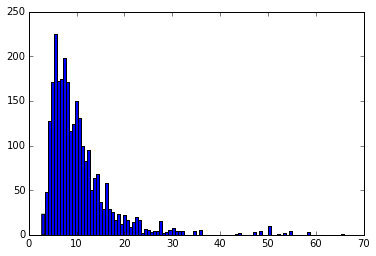

Mean sample coverage = 10.51 (+/3.41) 


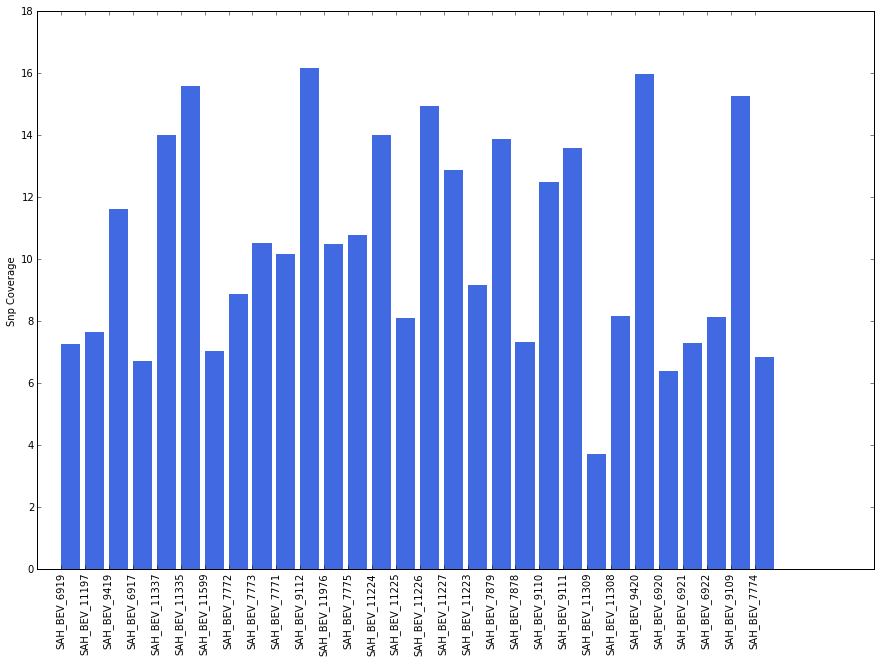

In [4]:
final_vcf = "/home/djeffrie/Data/RADseq/Psaharicus/batch_1.vcf"
final_popmap = "/home/djeffrie/Data/RADseq/Psaharicus/batch_1.vcf"

MISC.av_tag_cov(final_vcf, "//home/djeffrie/Data/RADseq/Psaharicus/Av_tag_cov.out")
MISC.sample_Avcov_from_vcf(final_vcf)


In [5]:
%%bash

wd=/home/djeffrie/Data/RADseq/Psaharicus/  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered.vcf --recode A --allow-extra-chr -out $wd/batch_1_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Psaharicus//batch_1_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Psaharicus//batch_1_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Psaharicus//batch_1_altered.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf: /home/djeffrie/Data/RADseq/Psaharicus//batch_1_plink-temporary.bed +
/home/djeffrie/Data/RADseq/Psaharicus//batch_1_plink-temporary.bim +
/home/djeffrie/Data/RADseq/Psaharicus//batch_1_plink-temporary.fam written.
2731 variants loaded from .bim file.
30 people (0 males, 0 females, 30 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/home/djeffrie/Data/RADseq/Psaharicus//batch_1_plink.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 30 founders and 0 nonfounders pres

In [7]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Psaharicus/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("sex_info.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Saving 19.7 x 19.7 in image

  warnings.warn(x, RRuntimeWarning)


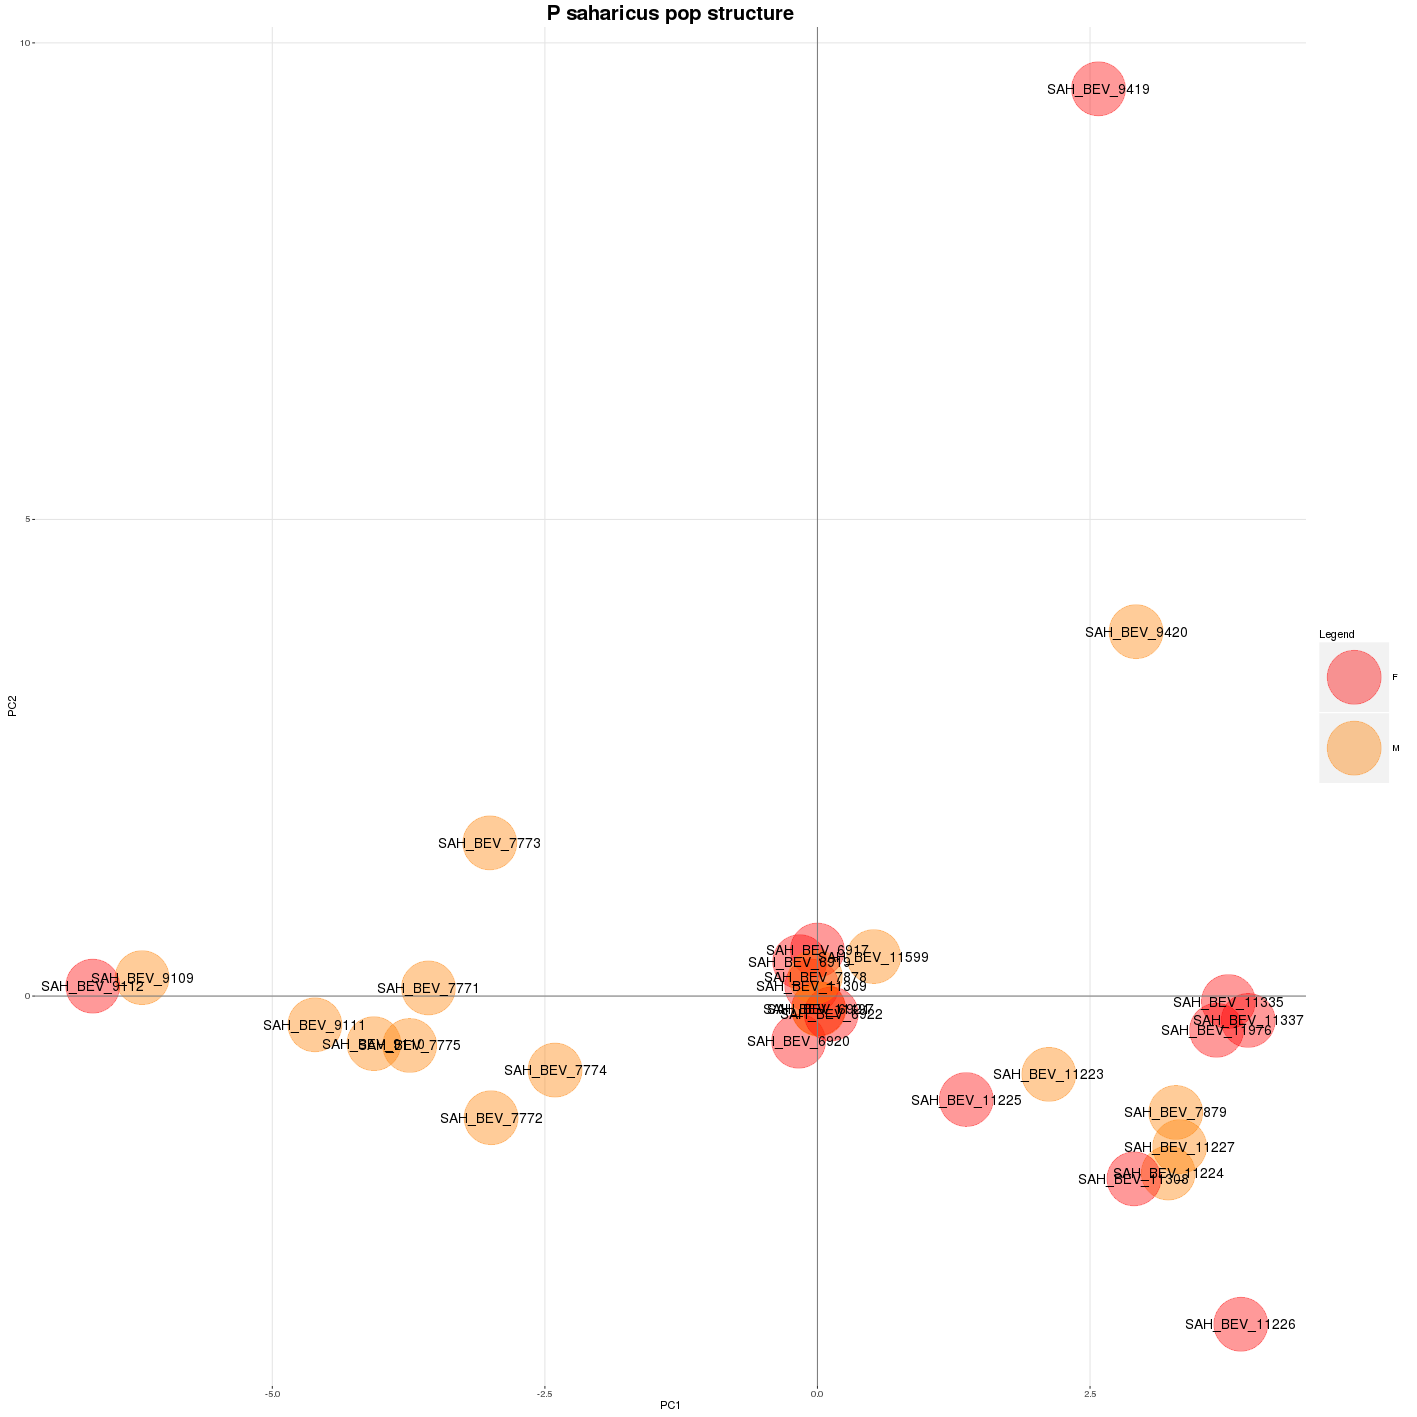

In [8]:
%%R -w 50 -h 50 -u cm
sexes <- read.delim("sex_info.txt", header = F)
## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "P saharicus pop structure", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

### Now find sex linked markers using the 3 approaches in Brelsford & Lavanchy et al (2016)

### Relaxed parameters for finding sex linkage

In [13]:
Parameter_dict = {}

## NOTE. DICT KEY NAMES MUST NOT BE CHANGED!

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Psaharicus/Sex_linked_markers/batch_1.catalog.tags.tsv" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Psaharicus/Sex_linked_markers/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Psaharicus/Sex_linked_markers/Sex_ID_info_kept.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 0.9 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 0.9 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.5 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.6 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 2810
Number of samples = 21
Number of loci with too few samples = 1255
Number of loci with low MAF = 1160
Number of loci with enough data = 394
Number of putative X linked snps = 4
Number of putative X linked tags = 4
Number of putative Z linked markers = 5
Number of putative Z linked tags = 5


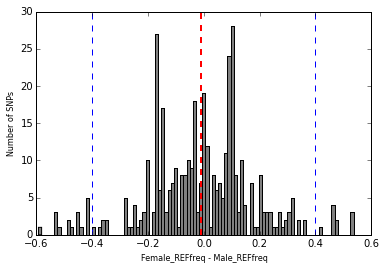


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 2810
Number of samples = 21
Number of loci with too few samples = 1255
Number of loci with low MAF = 1160
Number of loci with enough data = 394
Number of putative X linked snps = 0
Number of putative X linked tags = 0
Number of putative Z linked markers = 0
Number of putative Z linked tags = 0

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of males: 8
Number of males: 13
Number of Putative Y linked tags: 30
Number of Putative W linked tags: 2

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Psaharicus/Sex_linked_markers

 ## After merging tags accross methods ## 

Final number of XY tags = 34
Final number of ZW tags = 7


/home/djeffrie/anaconda/lib/python2.7/site-packages/matplotlib_venn/_venn3.py:56: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")


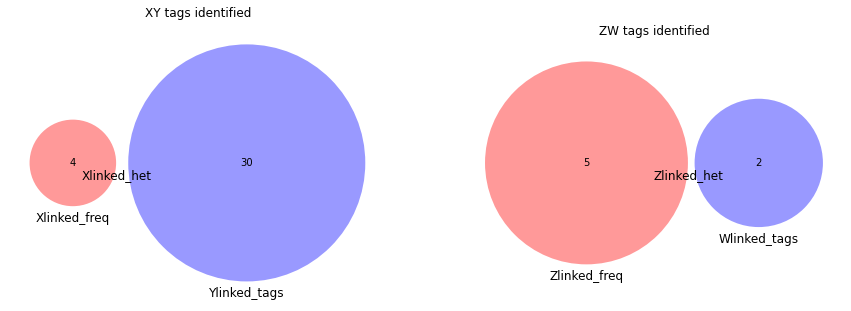

In [14]:
## homgam ref allele check
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

Number of tags =  42934
Average tag coverage 19.6388667551 (+- 14.761869708 )


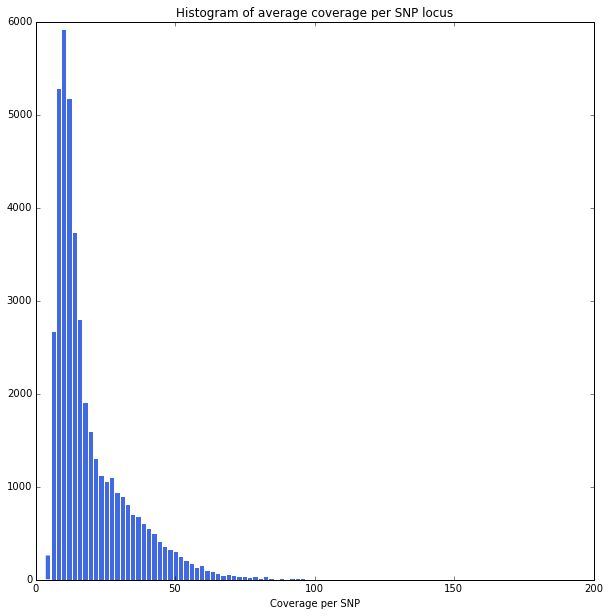

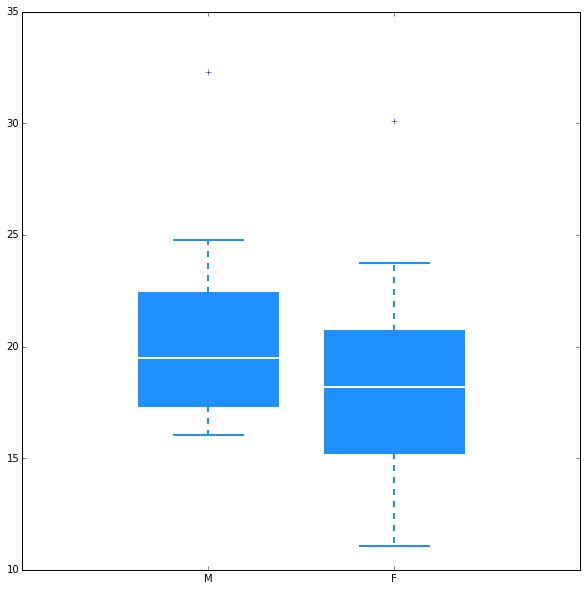

In [15]:
raw_means, pop_dict = MISC.Super_av_tag_cov("/home/djeffrie/Data/RADseq/Ryavapaiensis/Sex_linked_markers/batch_1.vcf", \
                       popmap = "/home/djeffrie/Data/RADseq/Ryavapaiensis/Sex_linked_markers/Sex_ID_info.txt")

Number of tags =  18
Average tag coverage 23.8070175439 (+- 13.6991371582 )


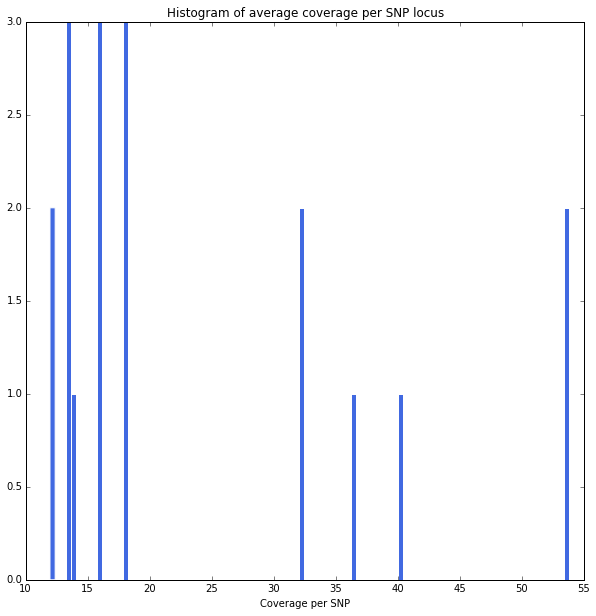

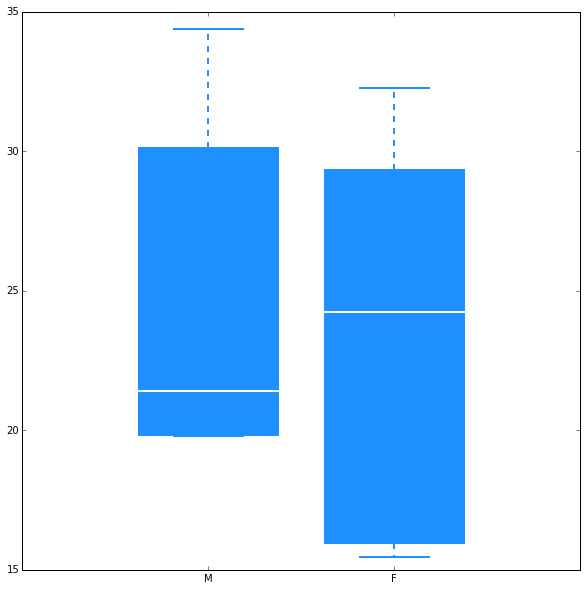

In [16]:
ZW_list = list(ZWset)
raw_means, pop_dict = MISC.Super_av_tag_cov("/home/djeffrie/Data/RADseq/Ryavapaiensis/Sex_linked_markers/batch_1.vcf", \
                       popmap = "/home/djeffrie/Data/RADseq/Ryavapaiensis/Sex_linked_markers/Sex_ID_info.txt", whitelist = ZW_list)

Number of tags =  43
Average tag coverage 21.7931456548 (+- 9.67052006693 )


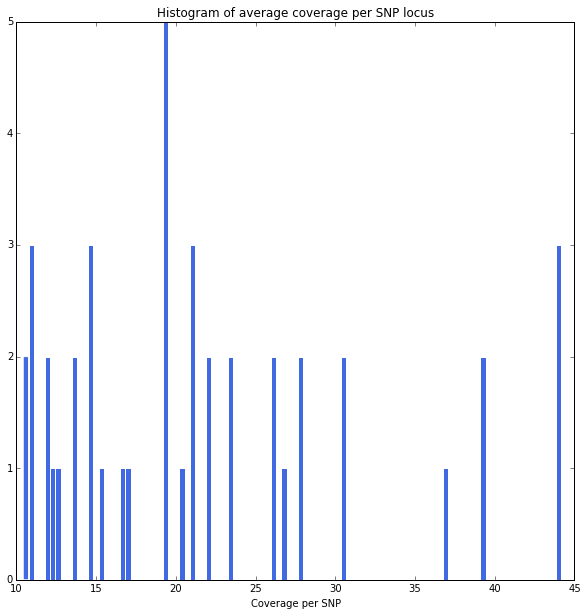

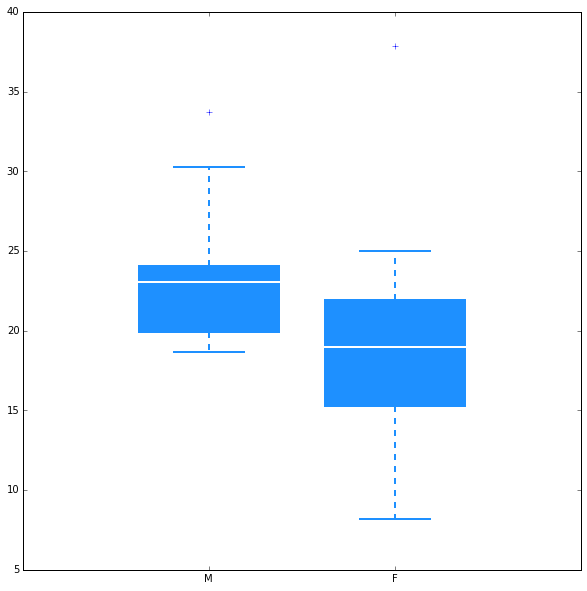

In [17]:
XY_list = list(XYset)
raw_means, pop_dict = MISC.Super_av_tag_cov("/home/djeffrie/Data/RADseq/Ryavapaiensis/Sex_linked_markers/batch_1.vcf", \
                       popmap = "/home/djeffrie/Data/RADseq/Ryavapaiensis/Sex_linked_markers/Sex_ID_info.txt", whitelist = XY_list)

## Summary:

This is a mixed bag. On the one hand it looks like there are a lot of false positives. These come mostly from the SNP approaches. However, there are a lot more Y specific tags. 

My guess would be that this is indeed an XY system, but I need to look at the source of these false positives if that is the case!!





### Ok trying again with the new library. . . .

Sequencing looks like it went well, but I am not absolutely sure about the barcodes . . . so I will have to take a look agains the layout and the PCA . . . 

In [8]:
%%bash

wd=/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered.vcf --recode A --allow-extra-chr -out $wd/batch_1_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1_altered.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1_plink-temporary.fam
written.
29787 variants loaded from .bim file.
28 people (0 males, 0 females, 28 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1_plink.nosex .

In [11]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("sex_info.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



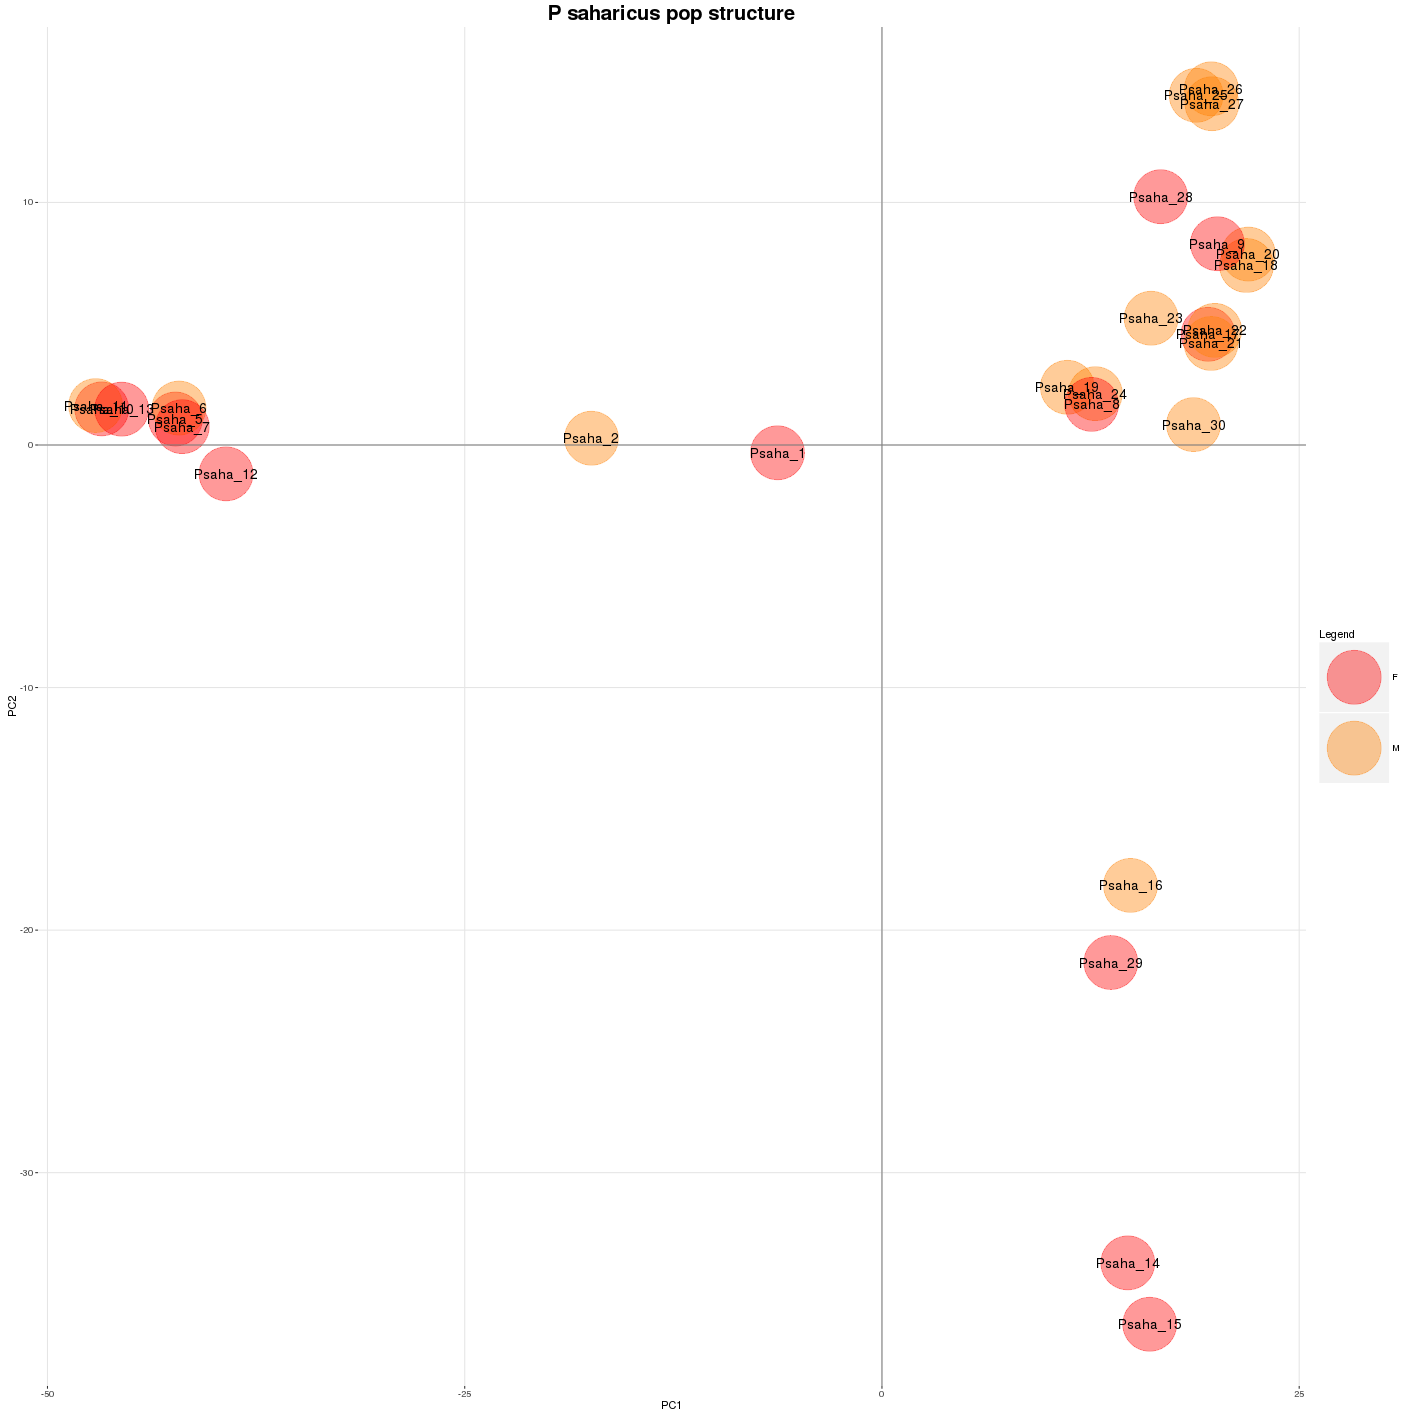

In [12]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "P saharicus pop structure", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

Number of tags =  29787
Average tag coverage 16.6772777194 (+- 6.79023587038 )


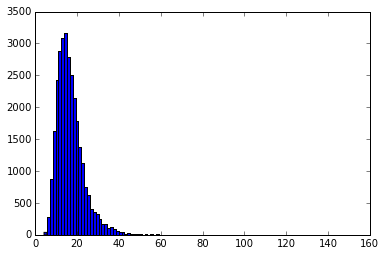

Mean sample coverage = 16.68 (+/6.56) 


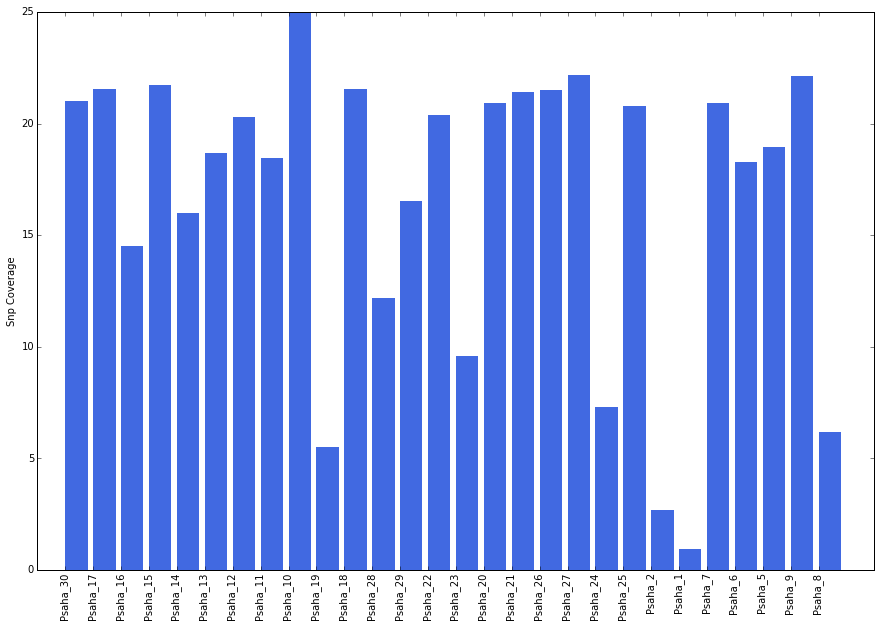

{'Psaha_1': [0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  4,
  0,
  0,
  0,
  3,
  0,
  0,
  11,
  0,
  0,
  0,
  0,
  0,
  0,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  10,
  3,
  3,
  4,
  4,
  0,
  0,
  4,
  4,
  4,
  4,
  0,
  3,
  3,
  3,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  14,
  14,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  3,
  3,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  11,
  11,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  4,
  4,
  4,
  4,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  5,
  5,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0

In [17]:
final_vcf = "/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1.vcf"
final_popmap = "/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/Sex_ID_info.txt"

MISC.av_tag_cov(final_vcf, "//home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/Av_tag_cov.out")
MISC.sample_Avcov_from_vcf(final_vcf)


In [15]:
Parameter_dict = {}

## NOTE. DICT KEY NAMES MUST NOT BE CHANGED!

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Psaharicus_2/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.5 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 7 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.6 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 29787
Number of samples = 28
Number of loci with too few samples = 10377
Number of loci with low MAF = 0
Number of loci with enough data = 19409
Number of putative X linked snps = 7
Number of putative X linked tags = 7
Number of putative Z linked markers = 11
Number of putative Z linked tags = 11


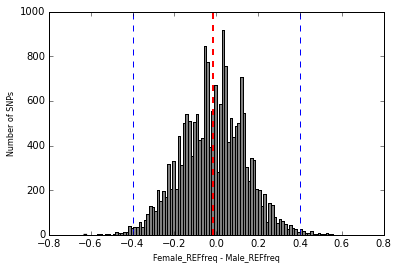


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 29787
Number of samples = 28
Number of loci with too few samples = 10375
Number of loci with low MAF = 0
Number of loci with enough data = 19409
Number of putative X linked snps = 40
Number of putative X linked tags = 40
Number of putative Z linked markers = 16
Number of putative Z linked tags = 16

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 13
Number of males: 15
Number of Putative Y linked tags: 2
Number of Putative W linked tags: 0

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Psaharicus_2

 ## After merging tags accross methods ## 

Final number of XY tags = 47
Final number of ZW tags = 27


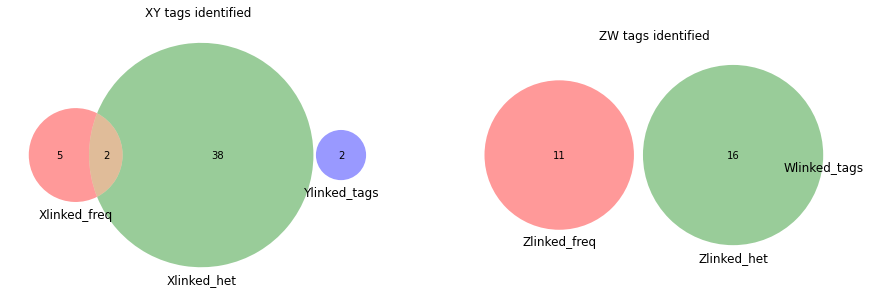

In [16]:
## homgam ref allele check
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

In [18]:
help(MISC.filter_vcf)

Help on function filter_vcf in module MISC_RAD_tools:

filter_vcf(vcfpath, tags_to_keep, outfile_name)
    Filters a vcf ("vcfpath"), keeping only the loci that are in the <list> "tags_to_keep"



In [20]:
MISC.filter_vcf(final_vcf, XYset, "XY_tags.vcf")

In [21]:
%%bash

wd=/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all  ## just change this line

## All data 
sed 's/_/-/g' $wd/XY_tags.vcf > $wd/XY_tags_altered.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/XY_tags_altered.vcf --recode A --allow-extra-chr -out $wd/XY_tags_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/XY_tags_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/XY_tags_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/XY_tags_altered.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/XY_tags_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/XY_tags_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/XY_tags_plink-temporary.fam
written.
45 variants loaded from .bim file.
28 people (0 males, 0 females, 28 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all/XY_tags_plink.nosex .
Us

In [22]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_all") 

## All SNPs (about 80,000)
alldata <- read.PLINK('XY_tags_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Sex information:
sexes <- read.delim("Sex_ID_info.txt", header = F)

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



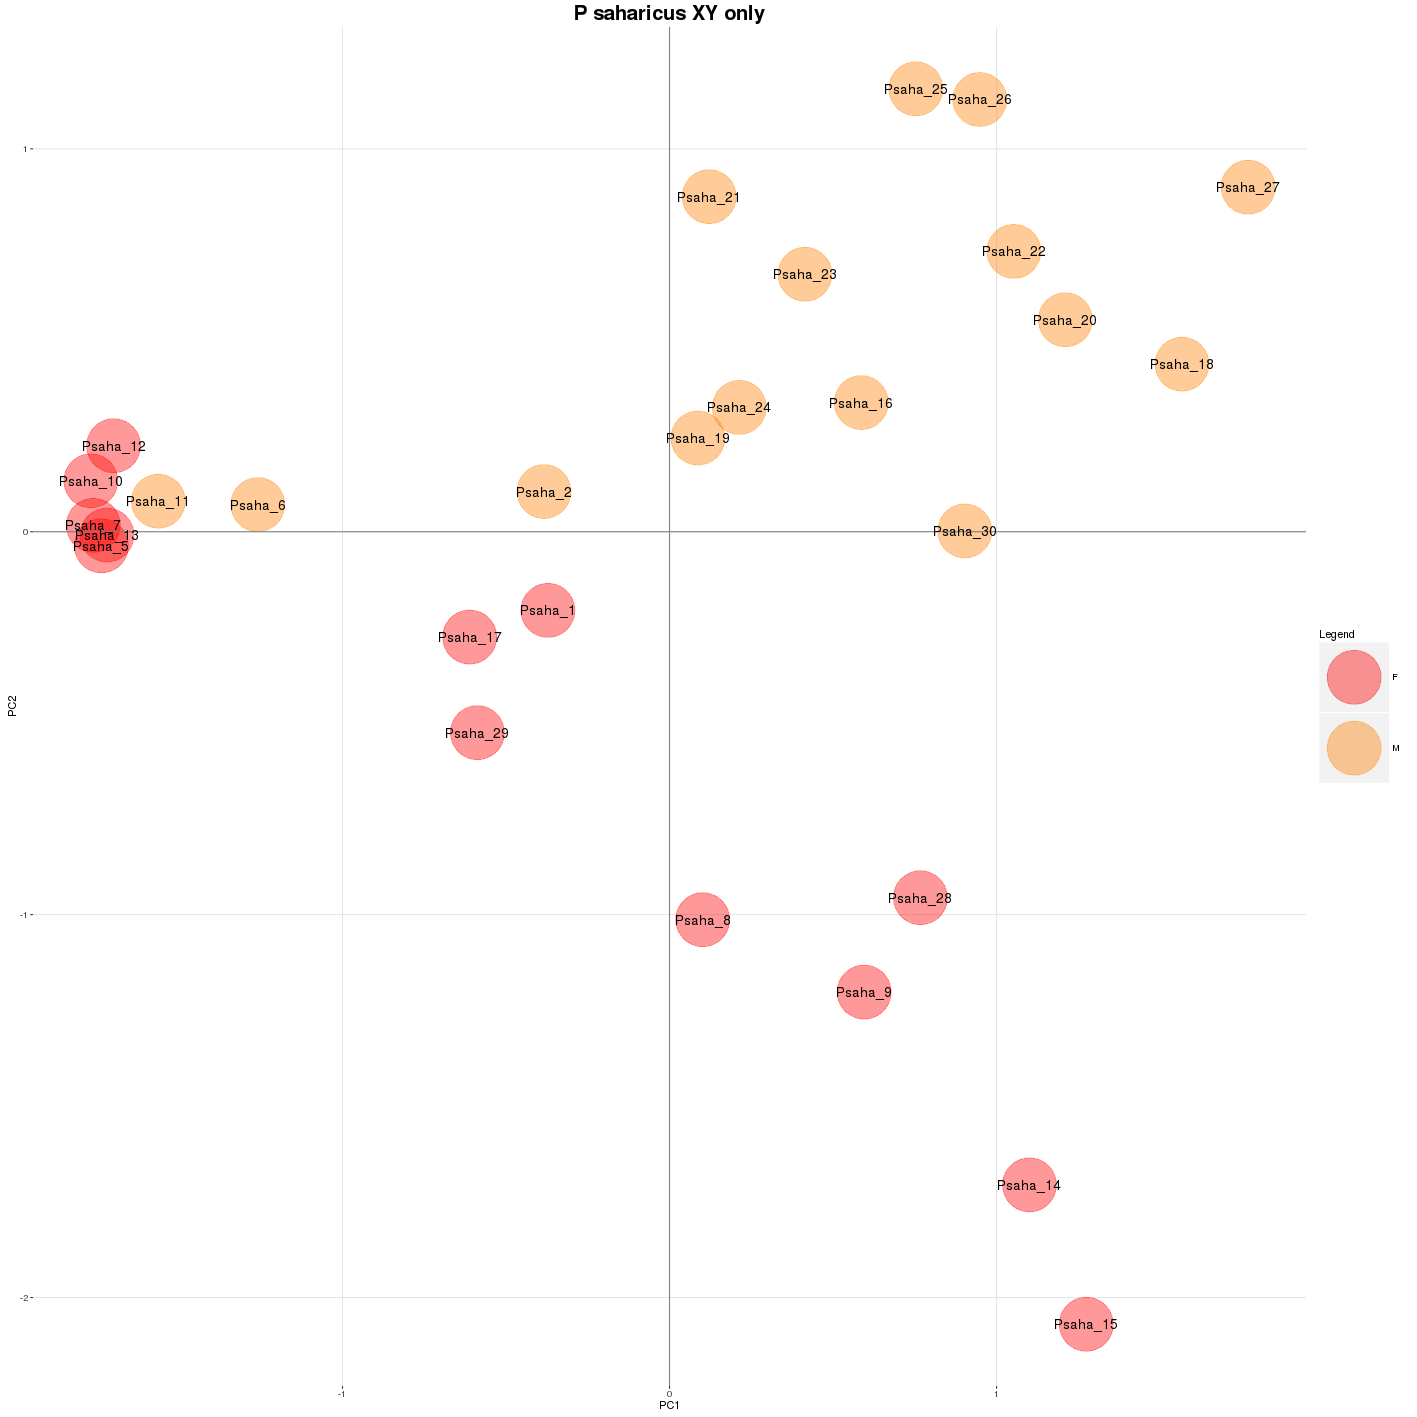

In [23]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "P saharicus XY only", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

Number of tags =  32282
Average tag coverage 16.6355377167 (+- 7.06310904981 )


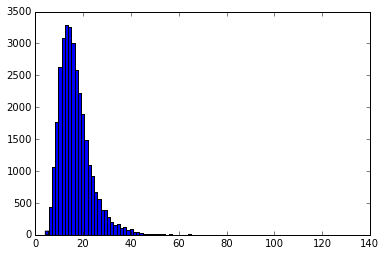

In [1]:
%matplotlib inline
import MISC_RAD_tools as MISC
wd = "/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_kept_group1/"
final_vcf = "%s/batch_1.vcf" % wd
MISC.av_tag_cov(final_vcf, "%s/Av_tag_cov.out" % wd)
#MISC.sample_Avcov_from_vcf(final_vcf)

In [34]:
Parameter_dict = {}

## NOTE. DICT KEY NAMES MUST NOT BE CHANGED!

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Psaharicus_2/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_kept_group1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Psaharicus_2/Populations_kept_group1/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 10 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.6 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 10 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.6 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 32282
Number of samples = 21
Number of loci with too few samples = 21025
Number of loci with low MAF = 0
Number of loci with enough data = 11256
Number of putative X linked snps = 23
Number of putative X linked tags = 23
Number of putative Z linked markers = 32
Number of putative Z linked tags = 32


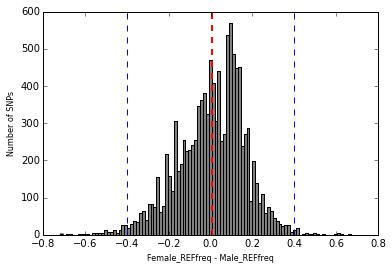


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 32282
Number of samples = 21
Number of loci with too few samples = 20888
Number of loci with low MAF = 0
Number of loci with enough data = 11256
Number of putative X linked snps = 14
Number of putative X linked tags = 14
Number of putative Z linked markers = 25
Number of putative Z linked tags = 25

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 7
Number of males: 14
Number of Putative Y linked tags: 26
Number of Putative W linked tags: 1

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Psaharicus_2

 ## After merging tags accross methods ## 

Final number of XY tags = 61
Final number of ZW tags = 54


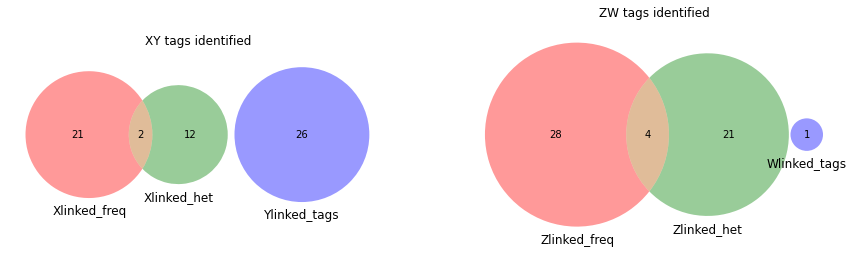

In [35]:
## homgam ref allele check
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")